# Importación de modulos

In [6]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import shutil
import pathlib
import itertools
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import os



import warnings
warnings.filterwarnings("ignore")

In [7]:
# generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        flist = os.listdir(foldpath)
        
        for f in flist:
            f_path = os.path.join(foldpath, f)
            filelist = os.listdir(f_path)
            
            for file in filelist:
                fpath = os.path.join(f_path, file)
                filepaths.append(fpath)

                if f == 'colon_aca':
                    labels.append('Adenocarcinoma de colon')

                elif f == 'colon_n':
                    labels.append('Tejido benigno del colon')

                elif f == 'lung_aca':
                    labels.append('Adenocarcinoma de pulmón')

                elif f == 'lung_n':
                    labels.append('Tejido benigno pulmonar')

                elif f == 'lung_scc':
                    labels.append('Carcinoma de células escamosas de pulmón')

    return filepaths, labels


# concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

#### **Functions to check data spliting format**

In [8]:
# function that contain only a directory of data and it is not splitted
def tr_ts_data(tr_dir, ts_dir):
    # train and valid dataframe
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # test dataframe
    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

# function that contain train and test directory of data.
def full_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df


# function that contain the three directory of data train, valid, and test
def tr_val_ts_data(tr_dir, val_dir, ts_dir):

    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

#### **Function to split data into train, valid, test**

In [9]:
def split_data(tr_dir, val_dir=None, ts_dir=None):
    '''
        This function split data into train, valid, and test after convert it to a dataframe.
        Dataset can be in several formats, it can contain train, valid, and test data, or it can contain only train and test data, etc.
        It depends on other needed function:
        - full_data function that contain only a directory of data and it is not splitted.
        - tr_ts_data function that contain train and test directory of data.
        - tr_val_ts_data function that contain the three directory of data train, valid, and test.
    '''

    # no Validation or Test data
    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    # no Validation data
    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    # sll data existed
    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

In [10]:
def create_model_data(data_dir, batch_size=40, img_size=(224, 224), val_split=0.2, test_split=0.1):
    """
    - Loads all images from a single directory (with subfolders for each class).
    - Randomly splits the data into train/val/test.
    - Returns pytorch DataLoaders.
    """

    # Transforms (augmentation + normalization)
    train_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    # load all data using ImageFolder
    full_dataset = ImageFolder(root=data_dir)

    # spplit indices for train/val/test
    total_size = len(full_dataset)
    indices = list(range(total_size))
    np.random.shuffle(indices)

    test_size = int(total_size * test_split)
    val_size = int(total_size * val_split)
    train_size = total_size - test_size - val_size

    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]

    # apply transforms by wrapping the Subset dataset with transform override
    def subset_with_transform(indices, transform):
        subset = Subset(full_dataset, indices)
        subset.dataset = ImageFolder(root=data_dir, transform=transform)
        return subset

    train_data = subset_with_transform(train_idx, train_transforms)
    val_data = subset_with_transform(val_idx, val_test_transforms)
    test_data = subset_with_transform(test_idx, val_test_transforms)

    
    test_batch_size = max(sorted([len(test_data) // n for n in range(1, len(test_data) + 1)
                                  if len(test_data) % n == 0 and len(test_data) / n <= 80]))

    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

    
    class_names = full_dataset.classes

    return train_loader, val_loader, test_loader, class_names

#### **Funcion para hacer un plot sobre imagenes del dataset**

In [11]:

def show_images(loader, class_names, normalize=True):
    """
    show a batch of sample images from a Pytorch DataLoader.

    Args:
        loader: Pytoorch DataLoader
        class_names: list of class names (from dataset.classes)
        normalize: if True, undoes normalization for display
    """
    images, labels = next(iter(loader))

    sample = min(len(images), 25)

    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        image = images[i]
        if normalize:
            image = image * 0.5 + 0.5  

        npimg = image.numpy().transpose((1, 2, 0))  
        plt.imshow(np.clip(npimg, 0, 1))
        plt.title(class_names[labels[i]], color='blue', fontsize=12)
        plt.axis('off')

    plt.show()


In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_label_count(loader, name='train'):
    subset = loader.dataset
    full_dataset = subset.dataset
    indices = subset.indices
    class_names = full_dataset.classes

    label_indices = [full_dataset.imgs[i][1] for i in indices]
    counts = Counter(label_indices)

    labels = [class_names[i] for i in counts.keys()]
    values = list(counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values)
    plt.title(f'Class Distribution - {name}')
    plt.xticks(rotation=45)
    plt.show()

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(labels, values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

#### **Callbacks** 


In [13]:
import time
import copy
import numpy as np
import torch

class MyCallback:
    def __init__(
        self,
        model,
        optimizer,
        patience,
        stop_patience,
        threshold,
        factor,
        batches,
        epochs,
        ask_epoch
    ):
        """
        Args:
            model (torch.nn.Module): PyTorch model.
            optimizer (torch.optim.Optimizer): PyTorch optimizer (e.g., Adam).
            patience (int): # epochs without improvement before LR is adjusted.
            stop_patience (int): # times to adjust LR without improvement before stopping.
            threshold (float): training accuracy threshold to decide which metric (train vs. val) to monitor.
            factor (float): factor by which to reduce LR on plateau.
            batches (int): number of training batches per epoch (for printing).
            epochs (int): total number of epochs you plan to run.
            ask_epoch (int or None): epoch at which to prompt the user (and then again after the user-specified interval).
        """
        self.model = model
        self.optimizer = optimizer
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

       
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.stop_training = False

       
        self.initial_lr = self.get_lr()
        
        self.best_state_dict = copy.deepcopy(self.model.state_dict())
        self.initial_state_dict = copy.deepcopy(self.model.state_dict())

        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
        }

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def set_lr(self, new_lr):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

    def on_train_begin(self):
        print('Do you want the model to ask you to halt training [y/n]?')
        ans = input().strip()
        if ans in ['y', 'Y']:
            self.ask_permission = True
        else:
            self.ask_permission = False

        header = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR',
            'Next LR', 'Monitor','% Improv', 'Duration'
        )
        print(header)
        self.start_time = time.time()

    def on_train_end(self):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = int(tr_duration // 3600)
        minutes = int((tr_duration % 3600) // 60)
        seconds = (tr_duration % 60)

        msg = f'Training elapsed time: {hours}h {minutes}m {seconds:.2f}s'
        print(msg)

        # Restore the best weights
        self.model.load_state_dict(self.best_state_dict)

    def on_train_batch_end(self, batch, logs=None):
        """logs should contain 'accuracy' and 'loss' for the batch."""
        acc = logs.get('accuracy', 0.0) * 100
        loss = logs.get('loss', 0.0)
        msg = (f"{' ':20s}processing batch {batch} of {self.batches} - "
               f"accuracy= {acc:.3f} - loss= {loss:.5f}")
        print(msg + '\r', end='')

    def on_epoch_begin(self, epoch):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        """
        logs should contain:
            'accuracy': float (training accuracy, 0..1),
            'loss': float (training loss),
            'val_accuracy': float (validation accuracy, 0..1),
            'val_loss': float (validation loss)
        """
        ep_end = time.time()
        duration = ep_end - self.ep_start

        acc = logs.get('accuracy', 0.0)
        v_acc = logs.get('val_accuracy', 0.0)
        loss = logs.get('loss', 0.0)
        v_loss = logs.get('val_loss', 0.0)

        current_lr = self.get_lr()
        new_lr = current_lr  # may update below

        self.history['train_loss'].append(loss)
        self.history['train_acc'].append(acc)
        self.history['val_loss'].append(v_loss)
        self.history['val_acc'].append(v_acc)

        # decide whether to monitor train accuracy or val_loss:
        if acc < self.threshold:
            # Monitor training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                # percentage improvement in train accuracy
                if self.highest_tracc > 0:
                    pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc
                else:
                    pimprov = acc * 100

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_state_dict = copy.deepcopy(self.model.state_dict())
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
            else:
                # no improvement in training accuracy
                if self.count >= self.patience - 1:
                    new_lr = current_lr * self.factor
                    self.set_lr(new_lr)
                    self.stop_count += 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count += 1
        else:
            # monitor val_loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                if self.lowest_vloss > 0 and v_loss != np.inf:
                    pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss
                else:
                    pimprov = 0.0

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_state_dict = copy.deepcopy(self.model.state_dict())
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                # val_loss did not improve
                if self.count >= self.patience - 1:
                    new_lr = current_lr * self.factor
                    self.set_lr(new_lr)
                    self.stop_count += 1
                    self.count = 0
                else:
                    self.count += 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = (f"{(epoch + 1):^3}/{self.epochs:^4} "
               f"{loss:^9.3f}{acc * 100:^9.3f}"
               f"{v_loss:^9.5f}{v_acc * 100:^9.3f}"
               f"{current_lr:^9.5f}{new_lr:^9.5f}"
               f"{monitor:^11s}{pimprov:^10.2f}"
               f"{duration:^8.2f}")
        print(msg)

        
        if self.stop_count >= self.stop_patience:
            stop_msg = (f"Training halted at epoch {epoch+1} after "
                        f"{self.stop_patience} LR adjustments without improvement.")
            print(stop_msg)
            self.stop_training = True
            return

    
        if self.ask_epoch is not None and self.ask_permission:
            if epoch + 1 >= self.ask_epoch:
                prompt_msg = ("Enter 'M' to halt training or an integer number of epochs "
                              "to run before asking again:")
                print(prompt_msg)
                ans = input().strip()
                if ans in ['M', 'm']:
                    print(f"Training halted by user at epoch {epoch+1}.")
                    self.stop_training = True
                else:
                    try:
                        more_epochs = int(ans)
                        self.ask_epoch += more_epochs
                        print(f"Training will continue until epoch {self.ask_epoch}.")
                        header = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^10s}{9:^8s}'.format(
                            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR',
                            'Next LR', 'Monitor', '% Improv', 'Duration'
                        )
                        print(header)
                    except ValueError:
                        print("Invalid input; continuing without change.")

In [14]:
def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


#### Confusion matrix plot

In [15]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Estructura del modelo

In [16]:
!pip install kagglehub

In [17]:
import kagglehub

In [18]:

path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Martin\.cache\kagglehub\datasets\andrewmvd\lung-and-colon-cancer-histopathological-images\versions\1


In [19]:
data_dir = 'C:/Users/Martin/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set'

os.listdir(os.path.join(data_dir, 'colon_image_sets'))

['colon_aca', 'colon_n']

In [ ]:
import os
import shutil

def combine_datasets(source_dirs, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    
    for src_dir in source_dirs:
        for class_folder in os.listdir(src_dir):
            src_class_path = os.path.join(src_dir, class_folder)
            dest_class_path = os.path.join(dest_dir, class_folder)

            os.makedirs(dest_class_path, exist_ok=True)

            for filename in os.listdir(src_class_path):
                src_file = os.path.join(src_class_path, filename)
                dest_file = os.path.join(dest_class_path, filename)
                shutil.copy2(src_file, dest_file)


combine_datasets(
    source_dirs=[
        'C:/Users/Martin/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set/colon_image_sets',
        'C:/Users/Martin/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set/lung_image_sets'
    ],
    dest_dir='C:/Users/Martin/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set/lung_colon_combined'
)

Visualización del dataset de manera grafica (images y etiquetas) y, por otro lado, la cantidad de elementos (imagenes) por clase del dataset

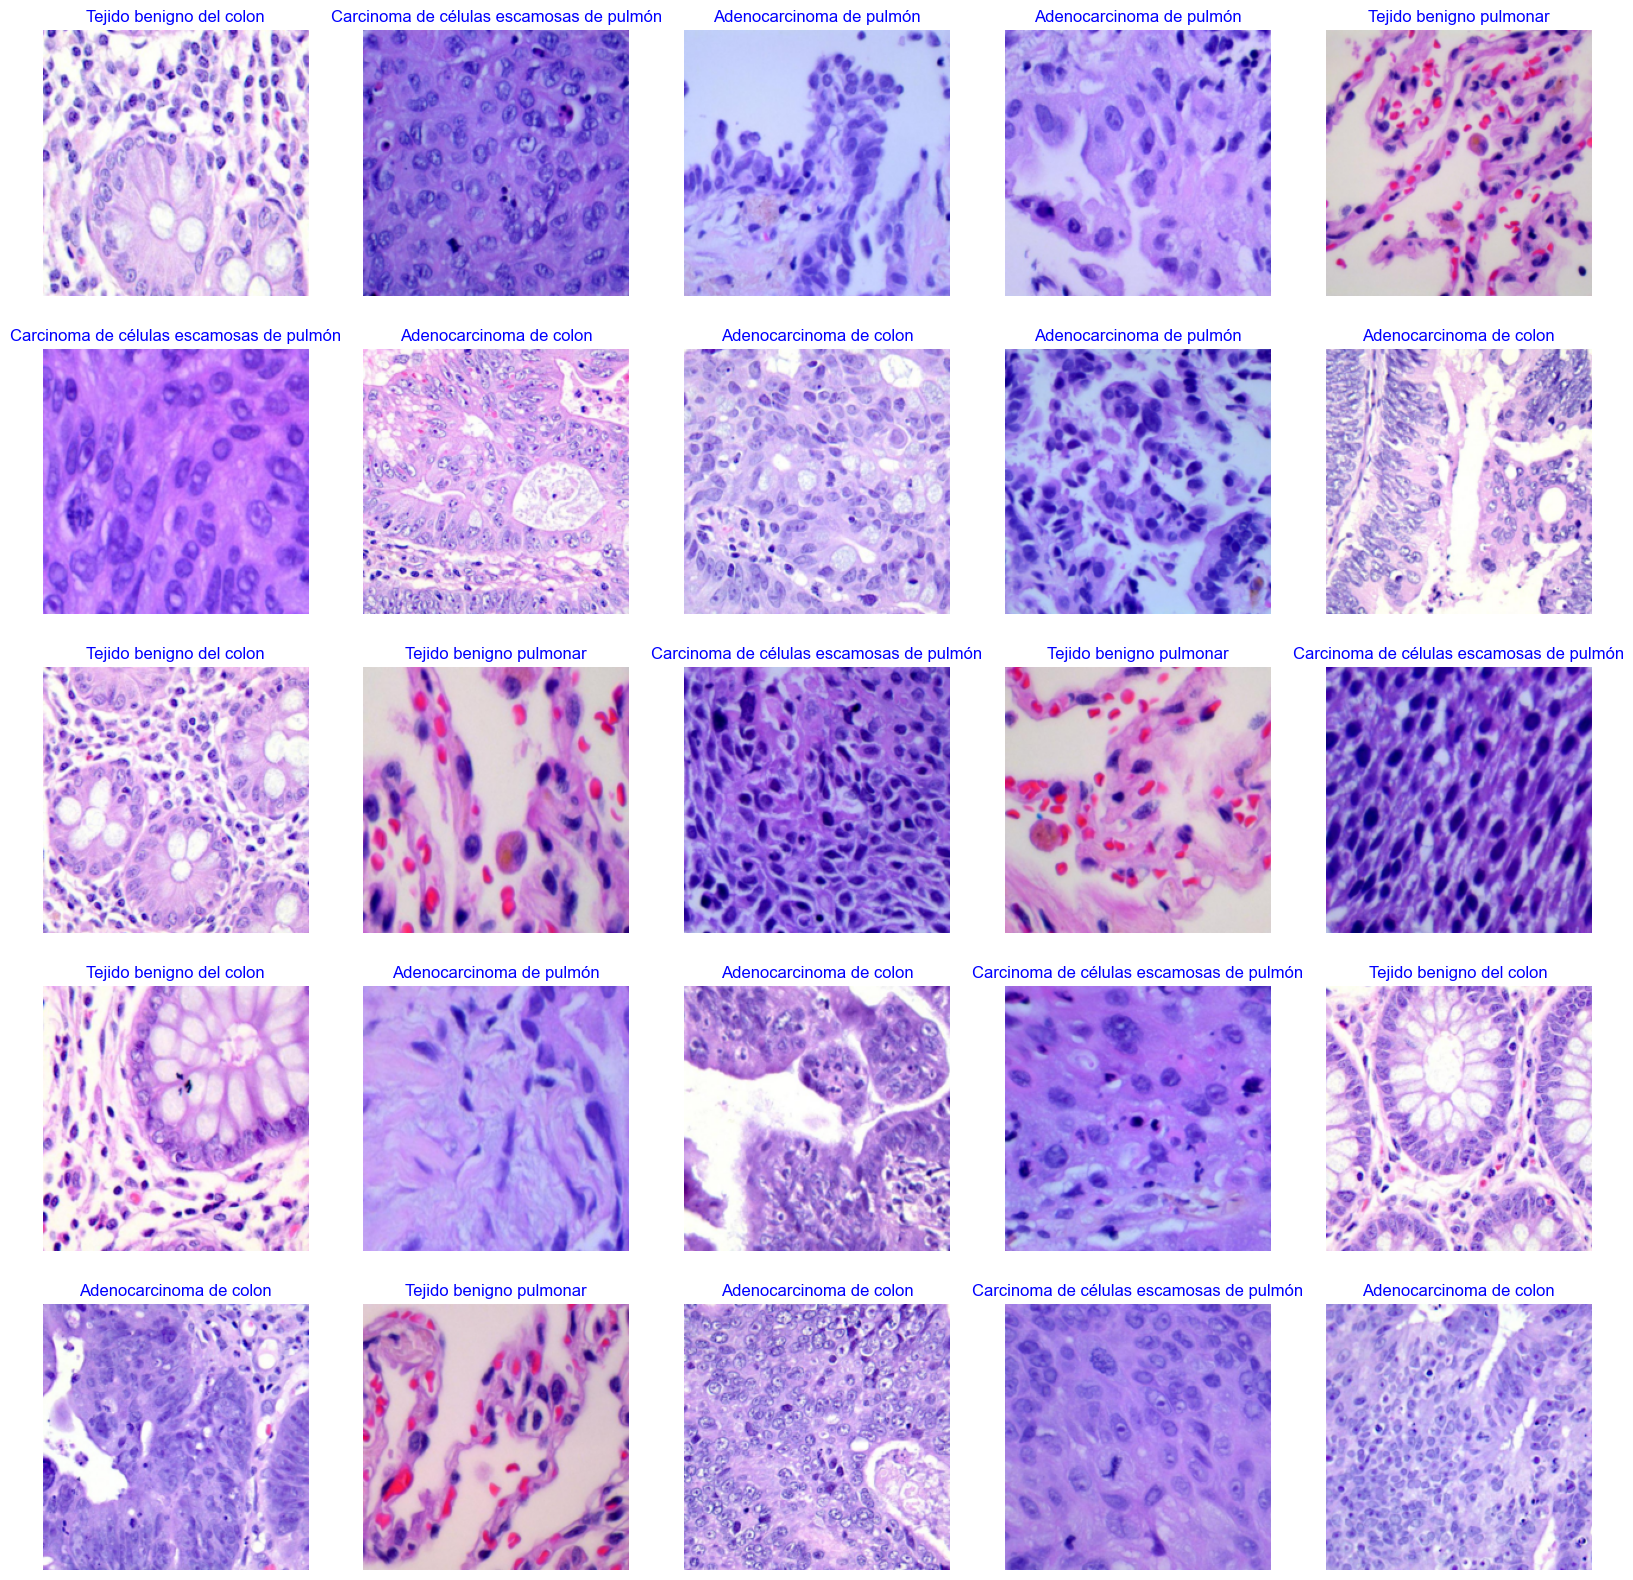

In [50]:
data_dir = 'C:/Users/Martin/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set/lung_colon_combined'


label_map = {
    'colon_aca': 'Adenocarcinoma de colon',
    'colon_n': 'Tejido benigno del colon',
    'lung_aca': 'Adenocarcinoma de pulmón',
    'lung_n': 'Tejido benigno pulmonar',
    'lung_scc': 'Carcinoma de células escamosas de pulmón'
}

try:
    batch_size = 40
    train_gen, valid_gen, test_gen, class_names = create_model_data(
        data_dir=data_dir,
        batch_size=batch_size,
        img_size=(224, 224),
        val_split=0.2,
        test_split=0.1
    )
    final_class_names = [label_map[name] for name in class_names]

    # Visualizations
    show_images(train_gen,final_class_names)  
   

except Exception as e:
    print("An error occurred:", e)

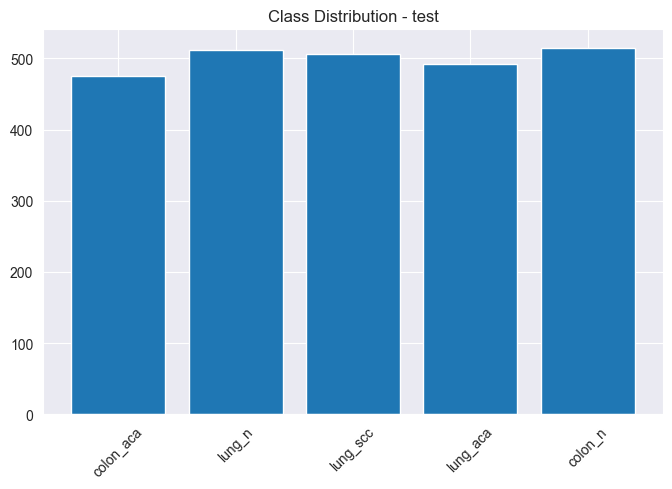

In [51]:
plot_label_count(test_gen, 'test')

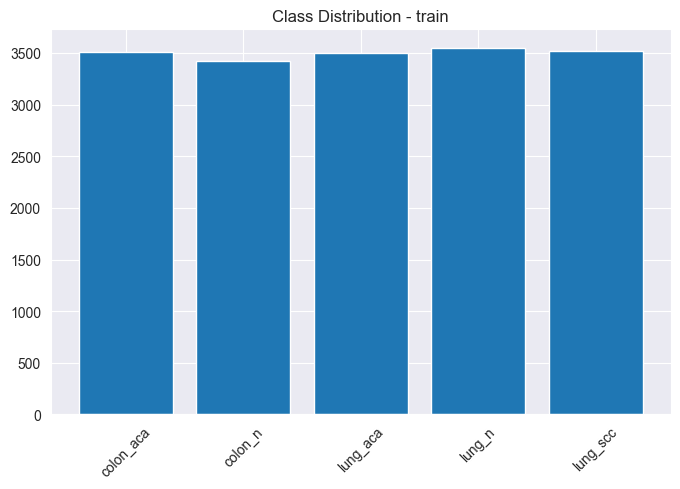

In [49]:
plot_label_count(train_gen, 'train')

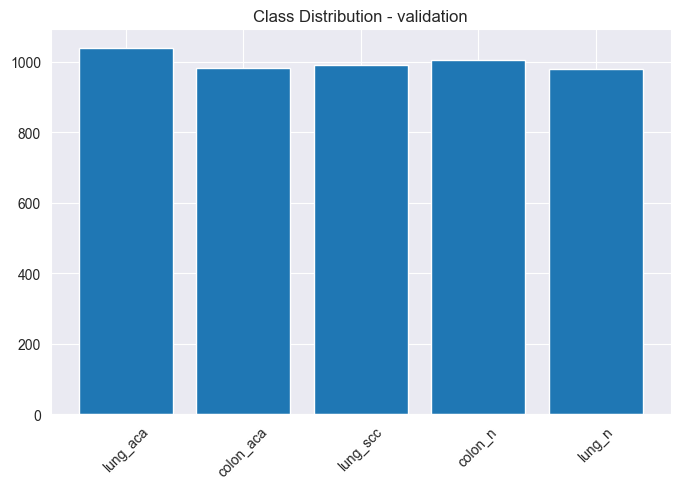

In [52]:
plot_label_count(valid_gen, 'validation')

Funciones de ayuda para el entrenamiento de modelos

In [22]:
def train_model(model, optimizer, train_loader, val_loader, criterion, epochs, callback, device='cpu'):
    """Similar to Keras's model.fit, but in PyTorch."""
    # on_train_begin
    callback.on_train_begin()

    model.to(device)

    for epoch in range(epochs):
        callback.on_epoch_begin(epoch)

        # ---- fase de training ----
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculation of training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train_samples += labels.size(0)
            total_train_loss += loss.item()

            # Logs for on_train_batch_end
            logs_batch = {
                'accuracy': correct_train / total_train_samples,
                'loss': total_train_loss / (batch_idx + 1)
            }
            callback.on_train_batch_end(batch_idx, logs_batch)

            if callback.stop_training:
                break

        if callback.stop_training:
            break

        epoch_train_acc = correct_train / total_train_samples
        epoch_train_loss = total_train_loss / len(train_loader)

        # ---- fase de validacion ----
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val_samples = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                correct_val += torch.sum(val_preds == val_labels).item()
                total_val_samples += val_labels.size(0)
                total_val_loss += val_loss.item()

        epoch_val_acc = correct_val / total_val_samples
        epoch_val_loss = total_val_loss / len(val_loader)

        
        logs_epoch = {
            'accuracy': epoch_train_acc,
            'loss': epoch_train_loss,
            'val_accuracy': epoch_val_acc,
            'val_loss': epoch_val_loss
        }
        callback.on_epoch_end(epoch, logs_epoch)

        if callback.stop_training:
            break

    # on_train_end
    callback.on_train_end()

    return model

In [23]:
def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    acc = correct / total_samples
    return avg_loss, acc, all_preds, all_labels

Se propone el siguiente manejo del trabajo que consiste en el desarrollo de 3 modelos de creciente complejidad hasta alcanzar una red neuronal similar a la planteada en VGG16 "Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556." Para eso, comenzaré desde tinyCNN que se plantea como una red neuronal minima con solo una capa convolucional y una capa FC (fully connected). Posteriormente, se planteará el desarrollo de SimpleCNN donde se desarrollará un modelo de 2 capas convolucionales y 1 capa FC. Finalmente, se plantea el modelo similara VGG16 con 5 capas convolucionales con MaxPooling y una capa FC.

### TinyCNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_dataset = train_gen.dataset
val_dataset   = valid_gen.dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



class TinyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TinyCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 224 → 112
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 112 * 112, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [ ]:
model = TinyCNN(num_classes=5)
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
callback = MyCallback(
    model=model,
    optimizer=optimizer,
    patience=1,
    stop_patience=3,
    threshold=0.9,
    factor=0.5,
    batches=len(train_loader),
    epochs=15,
    ask_epoch=5
)

trained_model = train_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    epochs=15,
    callback=callback,
    device='cuda'  
)

Do you want the model to ask you to halt training [y/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor   % Improv Duration
 1 / 15    1.616   18.926   1.61510  18.600   0.00003  0.00003  accuracy     0.00    156.97 
 2 / 15    1.616   18.703   1.61510  18.600   0.00003  0.00002  accuracy    -1.18    155.85 
 3 / 15    1.616   18.874   1.61510  18.600   0.00002  0.00001  accuracy    -0.27    162.29 
 4 / 15    1.616   19.229   1.61510  18.600   0.00001  0.00001  accuracy     1.60    161.03 
 5 / 15    1.616   18.691   1.61510  18.600   0.00001  0.00000  accuracy    -2.79    161.58 
 6 / 15    1.617   18.800   1.61510  18.600   0.00000  0.00000  accuracy    -2.23    156.38 
 7 / 15    1.617   18.857   1.61510  18.600   0.00000  0.00000  accuracy    -1.93    153.74 
Training halted at epoch 7 after 3 LR adjustments without improvement.
Training elapsed time: 0h 18m 27.86s


In [ ]:
device = 'cuda'
train_loss, train_acc, _, _ = evaluate_model(model, train_loader, criterion, device)
val_loss, val_acc, _, _     = evaluate_model(model, val_loader, criterion, device)
test_loss, test_acc, _, _   = evaluate_model(model, test_gen, criterion, device)

In [ ]:
# print results
print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_acc)
print('-' * 20)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_acc)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

Train Loss:  1.6164137751000112
Train Accuracy:  0.1881142857142857
--------------------
Validation Loss:  1.615100947380066
Validation Accuracy:  0.186
--------------------
Test Loss:  1.6156104922294616
Test Accuracy:  0.1856


In [ ]:
import torch
import numpy as np

model.eval()  
all_preds = []

with torch.no_grad():  
    for inputs, _ in test_gen:  
        inputs = inputs.to('cuda')  
        outputs = model(inputs)  # raw logits
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())  # move to CPU, convert to NumPy

y_pred = np.array(all_preds)
print(y_pred)

[3 2 2 ... 3 3 2]


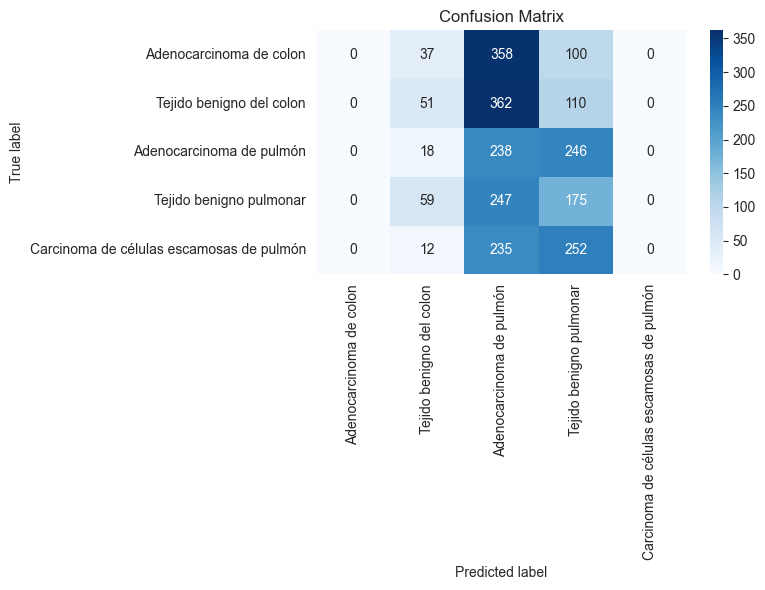

                                          precision    recall  f1-score   support

                 Adenocarcinoma de colon       0.00      0.00      0.00       495
                Tejido benigno del colon       0.29      0.10      0.15       523
                Adenocarcinoma de pulmón       0.17      0.47      0.25       502
                 Tejido benigno pulmonar       0.20      0.36      0.26       481
Carcinoma de células escamosas de pulmón       0.00      0.00      0.00       499

                                accuracy                           0.19      2500
                               macro avg       0.13      0.19      0.13      2500
                            weighted avg       0.13      0.19      0.13      2500



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

raw_classes = test_gen.dataset.dataset.classes  # ['colon_aca', 'colon_n', ...]
label_map = {
    'colon_aca': 'Adenocarcinoma de colon',
    'colon_n': 'Tejido benigno del colon',
    'lung_aca': 'Adenocarcinoma de pulmón',
    'lung_n': 'Tejido benigno pulmonar',
    'lung_scc': 'Carcinoma de células escamosas de pulmón'
}
final_class_names = [label_map[c] for c in raw_classes]

# true labels from test set
y_true = [label for _, label in test_gen.dataset]
y_true = np.array(y_true)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, final_class_names, title='Confusion Matrix')


print(classification_report(y_true, y_pred, target_names=final_class_names))

Se puede observar que una red neuronal tan sencilla como tinyCNN no puede identificar caracteristicas en las imagenes que le permitan diferenciar entre las 5 clases. Esto se aprecia en un accuracy bajo de 0.19 y multiples errores en la predicción. Basicamente, ninguna imagen se predijo para las categorias "Carcinoma de células escamosas de pulmón" o "Adenocarcinoma de colon"

### SimpleCNN

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(56 * 56 * 64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    

model = SimpleCNN(num_classes=5)

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_dataset = train_gen.dataset
val_dataset   = valid_gen.dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

callback = MyCallback(
    model=model,
    optimizer=optimizer,
    patience=1,
    stop_patience=3,
    threshold=0.9,
    factor=0.5,
    batches=len(train_loader),
    epochs=15,
    ask_epoch=5
)

trained_model = train_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    epochs=15,
    callback=callback,
    device='cuda'  
)

Do you want the model to ask you to halt training [y/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor   % Improv Duration
 1 / 15    0.442   83.497   0.30774  86.340   0.00100  0.00100  accuracy     0.00    161.76 
 2 / 15    0.202   92.063   0.18754  93.500   0.00100  0.00100  val_loss    39.06    157.76 
 3 / 15    0.126   95.440   0.12752  95.160   0.00100  0.00100  val_loss    32.01    154.81 
 4 / 15    0.087   96.834   0.12163  95.140   0.00100  0.00100  val_loss     4.62    154.90 
 5 / 15    0.056   98.154   0.07867  97.480   0.00100  0.00100  val_loss    35.32    156.78 
 6 / 15    0.037   98.869   0.08363  97.180   0.00100  0.00050  val_loss    -6.30    156.84 
 7 / 15    0.018   99.543   0.07317  97.540   0.00050  0.00050  val_loss     7.00    171.41 
 8 / 15    0.013   99.697   0.07139  97.760   0.00050  0.00050  val_loss     2.42    172.47 
 9 / 15    0.010   99.783   0.06534  97.900   0.00050  0.00050  val_loss     8.48    171.75 
10 / 15    0.0

In [25]:
device = 'cuda'
train_loss, train_acc, _, _ = evaluate_model(model, train_loader, criterion, device)
val_loss, val_acc, _, _     = evaluate_model(model, val_loader, criterion, device)
test_loss, test_acc, _, _   = evaluate_model(model, test_gen, criterion, device)

In [26]:
# print results
print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_acc)
print('-' * 20)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_acc)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

Train Loss:  0.0025454710896371984
Train Accuracy:  0.9998285714285714
--------------------
Validation Loss:  0.0625111210567411
Validation Accuracy:  0.9804
--------------------
Test Loss:  0.07169604084454477
Test Accuracy:  0.9804


In [27]:
import torch
import numpy as np

model.eval()  
all_preds = []

with torch.no_grad():  
    for inputs, _ in test_gen:  
        inputs = inputs.to('cuda')  
        outputs = model(inputs)  # raw logits
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())  # move to CPU, convert to NumPy

y_pred = np.array(all_preds)
print(y_pred)

[2 3 2 ... 4 4 4]


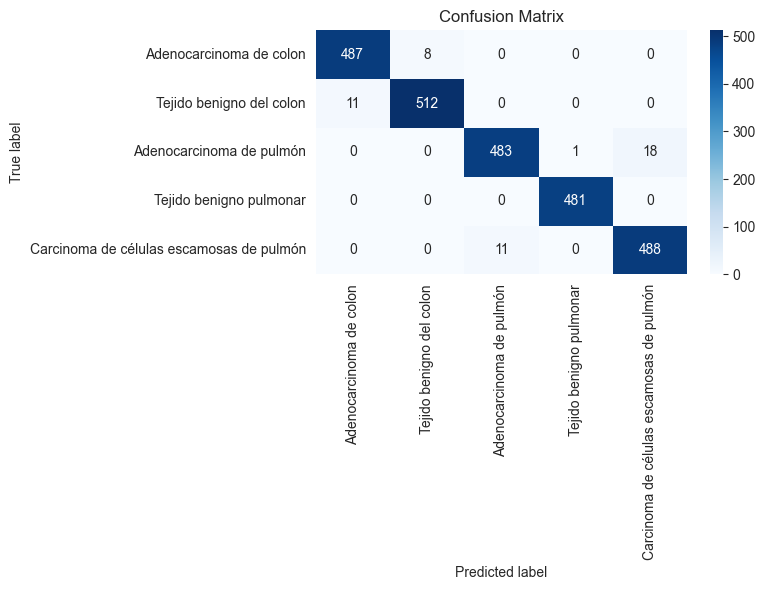

                                          precision    recall  f1-score   support

                 Adenocarcinoma de colon       0.98      0.98      0.98       495
                Tejido benigno del colon       0.98      0.98      0.98       523
                Adenocarcinoma de pulmón       0.98      0.96      0.97       502
                 Tejido benigno pulmonar       1.00      1.00      1.00       481
Carcinoma de células escamosas de pulmón       0.96      0.98      0.97       499

                                accuracy                           0.98      2500
                               macro avg       0.98      0.98      0.98      2500
                            weighted avg       0.98      0.98      0.98      2500



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

raw_classes = test_gen.dataset.dataset.classes  
label_map = {
    'colon_aca': 'Adenocarcinoma de colon',
    'colon_n': 'Tejido benigno del colon',
    'lung_aca': 'Adenocarcinoma de pulmón',
    'lung_n': 'Tejido benigno pulmonar',
    'lung_scc': 'Carcinoma de células escamosas de pulmón'
}
final_class_names = [label_map[c] for c in raw_classes]

# true labels from test set
y_true = [label for _, label in test_gen.dataset]
y_true = np.array(y_true)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, final_class_names, title='Confusion Matrix')


print(classification_report(y_true, y_pred, target_names=final_class_names))

Llegado este punto, se puede concluir que el dataset podría ser trabajado con una red neuronal "medianamente" simple. De todas formas, procederé a trabajar con una red neuronal compleja para una puesta en practica de otros conceptos vistos durante la carrera de especialización. Para esto, como antes mencioné, me basaré en el formato de VGG16 del año 2014.

### VGG16StyleModel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGGStyleModel(nn.Module):
    def __init__(self, num_classes=10): 
        super(VGGStyleModel, self).__init__()

        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224 -> 112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112 -> 56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56 -> 28

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28 -> 14

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 14 -> 7
        )

        # after 5 max pools (2x2 each), 224x224 becomes 7x7.
        # So the flattened feature map size is 512 * 7 * 7 = 25088.
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        # Pass input through the conv/pool block
        x = self.features(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Pass through the fully-connected "classifier"
        x = self.classifier(x)
        return x

#### Set Callback Parameters

In [ ]:
import math
import torch
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 40         
epochs = 15            
patience = 1            # number of epochs to wait before adjusting LR if no improvement
stop_patience = 3       # number of LR adjustments without improvement before stopping
threshold = 0.9         # if train acc < threshold => monitor training accuracy; else monitor val_loss
factor = 0.5            # factor by which to reduce LR
ask_epoch = 5           # after how many epochs to prompt user (e.g. "H" to halt)
 

train_dataset = train_gen.dataset
val_dataset   = valid_gen.dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


batches = len(train_loader)

model = VGGStyleModel(num_classes=5)
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

callback = MyCallback(
    model=model,
    optimizer=optimizer,      
    patience=patience,
    stop_patience=stop_patience,
    threshold=threshold,
    factor=factor,
    batches=batches,
    epochs=epochs,
    ask_epoch=ask_epoch
)



#  call train_model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    epochs=epochs,
    callback=callback,
    device='cuda' 
)

Do you want the model to ask you to halt training [y/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor   % Improv Duration
 1 / 15    0.694   65.840   0.37794  85.420   0.00100  0.00100  accuracy     0.00    205.93 
 2 / 15    0.306   88.354   0.31636  86.620   0.00100  0.00100  accuracy    34.20    203.30 
 3 / 15    0.231   91.326   0.19781  92.360   0.00100  0.00100  val_loss    37.47    202.63 
 4 / 15    0.199   92.646   0.20091  93.060   0.00100  0.00050  val_loss    -1.57    201.73 
 5 / 15    0.138   95.200   0.12700  95.800   0.00050  0.00050  val_loss    35.80    200.58 
 6 / 15    0.123   95.583   0.07875  97.220   0.00050  0.00050  val_loss    37.99    200.53 
 7 / 15    0.097   96.486   0.08960  96.660   0.00050  0.00025  val_loss    -13.78   200.79 
 8 / 15    0.065   97.629   0.12109  95.720   0.00025  0.00013  val_loss    -53.76   201.07 
 9 / 15    0.045   98.309   0.06372  97.860   0.00013  0.00013  val_loss    19.09    199.47 
10 / 15    0.0

Dado que me encontré con resultados demasiado buenos en el entrenamiento del modelo, procedí a hacer un split en 5 folds. La premisa sobre la que me sostengo es que existe la posibilidad que la combinación de los datos haga que los resultados sea así de bueno. Por esta razon, introduciendo variaciones en los splits de imagenes podría encontrar situaciones donde la precisión o perdida varie

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import numpy as np

# Número de folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)


full_dataset = train_gen.dataset


fold_results = []

# K-Fold loop
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_dataset)))):
    print(f"\n--- Fold {fold + 1} / {k} ---")

    # crear datasets para el fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # dataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # modelo nuevo para cada fold
    model = VGGStyleModel(num_classes=5)
    model.to('cuda')

    # Optimizer y loss
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    callback = MyCallback(
        model=model,
        optimizer=optimizer,
        patience=patience,
        stop_patience=stop_patience,
        threshold=threshold,
        factor=factor,
        batches=len(train_loader),
        epochs=epochs,
        ask_epoch=ask_epoch
    )

    # Entrenar el modelo para este fold
    trained_model = train_model(
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        epochs=epochs,
        callback=callback,
        device='cuda'
    )

    # Evaluar en el val set de este fold
    val_loss, val_acc, _, _ = evaluate_model(trained_model, val_loader, criterion, device='cuda')
    fold_results.append((val_loss, val_acc))
    print(f"Fold {fold + 1} - Validation Accuracy: {val_acc:.4f}")

# Resultados finales
avg_loss = np.mean([res[0] for res in fold_results])
avg_acc = np.mean([res[1] for res in fold_results])
print("\n===== K-FOLD RESULTADOS =====")
for i, (l, a) in enumerate(fold_results):
    print(f"Fold {i+1}: Loss={l:.4f}, Accuracy={a:.4f}")
print(f"\nPromedio: Loss={avg_loss:.4f}, Accuracy={avg_acc:.4f}")



--- Fold 1 / 5 ---
Do you want the model to ask you to halt training [y/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor   % Improv Duration
 1 / 15    0.801   61.193   0.43906  84.714   0.00100  0.00100  accuracy     0.00    158.52 
 2 / 15    0.360   85.136   0.33240  87.571   0.00100  0.00100  accuracy    39.13    158.33 
 3 / 15    0.285   88.236   0.23452  91.371   0.00100  0.00100  accuracy     3.64    158.21 
 4 / 15    0.232   90.864   0.24691  92.143   0.00100  0.00050  val_loss    -5.29    157.81 
 5 / 15    0.152   94.429   0.12939  95.314   0.00050  0.00050  val_loss    44.83    158.52 
 6 / 15    0.138   94.614   0.12265  95.200   0.00050  0.00050  val_loss     5.21    157.95 
 7 / 15    0.124   95.329   0.16300  93.914   0.00050  0.00025  val_loss    -32.90   157.89 
 8 / 15    0.082   96.936   0.08713  96.657   0.00025  0.00025  val_loss    28.96    158.37 
 9 / 15    0.072   97.257   0.10817  95.686   0.00025  0.00013  val_loss    -24.15   15

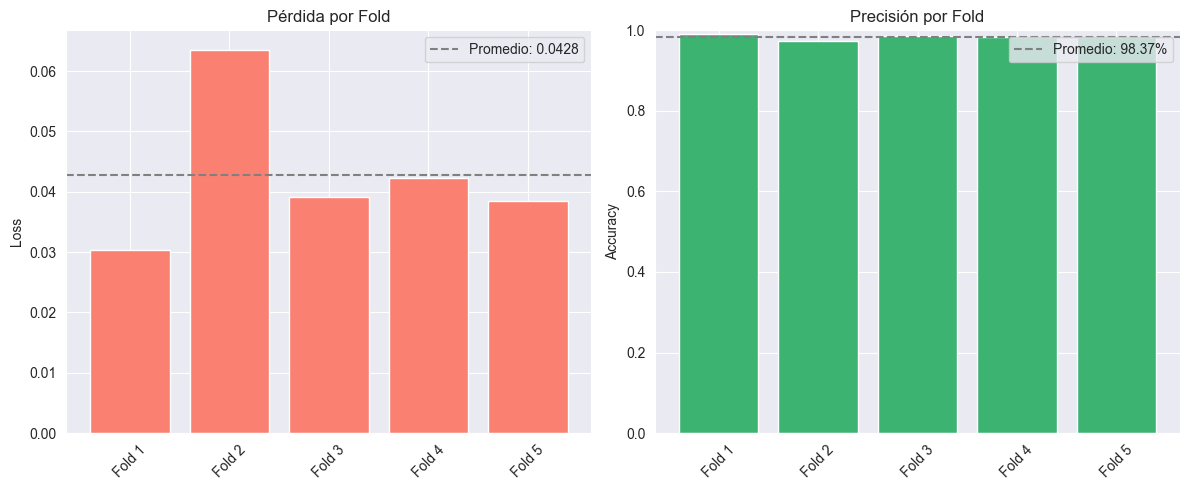

In [ ]:
import matplotlib.pyplot as plt

# fividimos loss y accuracy
fold_losses = [res[0] for res in fold_results]
fold_accuracies = [res[1] for res in fold_results]
fold_indices = [f"Fold {i+1}" for i in range(len(fold_results))]


avg_loss = np.mean(fold_losses)
avg_acc = np.mean(fold_accuracies)

plt.figure(figsize=(12, 5))

# plot loss per fold
plt.subplot(1, 2, 1)
plt.bar(fold_indices, fold_losses, color='salmon')
plt.axhline(avg_loss, color='gray', linestyle='--', label=f'Promedio: {avg_loss:.4f}')
plt.title("Pérdida por Fold")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.legend()

# plot accuracy per fold
plt.subplot(1, 2, 2)
plt.bar(fold_indices, fold_accuracies, color='mediumseagreen')
plt.axhline(avg_acc, color='gray', linestyle='--', label=f'Promedio: {avg_acc:.2%}')
plt.title("Precisión por Fold")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

Finalmente, encontré que los resultados del modelo diferian levemente entre los distintos folds. Por esta razón, asumo que la alta precisión y baja perdida del modelo entrenado no son causadas por la organización del dataset

#### Función para graficar esquema del modelo VGG16

In [ ]:
from torchviz import make_dot
import torch

model.eval() 


dummy_input = torch.randn(1, 3, 224, 224).to(next(model.parameters()).device)


output = model(dummy_input)

#create and save the visualization
make_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png")



'model_architecture.png'

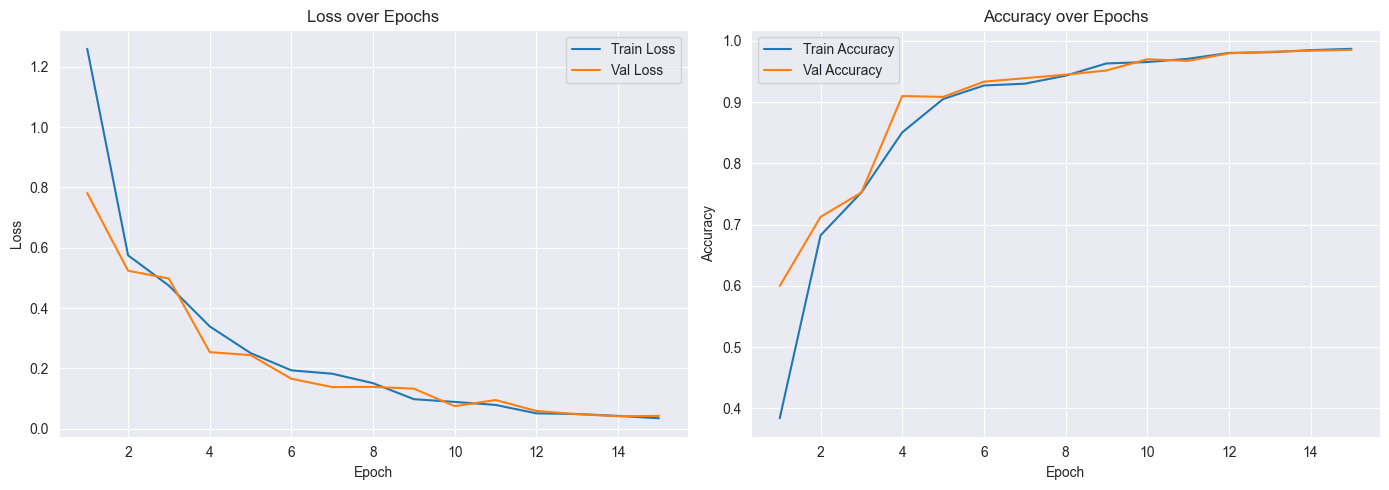

In [25]:
plot_training(callback.history)

### Evaluación del modelo VGG16

In [ ]:
device = 'cuda'

# Evaluate
train_loss, train_acc, _, _ = evaluate_model(model, train_loader, criterion, device)
val_loss, val_acc, _, _     = evaluate_model(model, val_loader, criterion, device)
test_loss, test_acc, _, _   = evaluate_model(model, test_gen, criterion, device)

# print results
print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_acc)
print('-' * 20)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_acc)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

Train Loss:  0.026236554490003203
Train Accuracy:  0.9905714285714285
--------------------
Validation Loss:  0.041306393686681986
Validation Accuracy:  0.9825714285714285
--------------------
Test Loss:  0.04503167313057929
Test Accuracy:  0.9852


In [ ]:
import torch
import numpy as np

model.eval()  
all_preds = []

with torch.no_grad():  
    for inputs, _ in test_gen:  
        inputs = inputs.to('cuda')  
        outputs = model(inputs)  # raw logits
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())  # move to CPU, convert to NumPy

y_pred = np.array(all_preds)
print(y_pred)

[4 2 0 ... 2 2 2]


#### Confusion Matrics and Classification Report

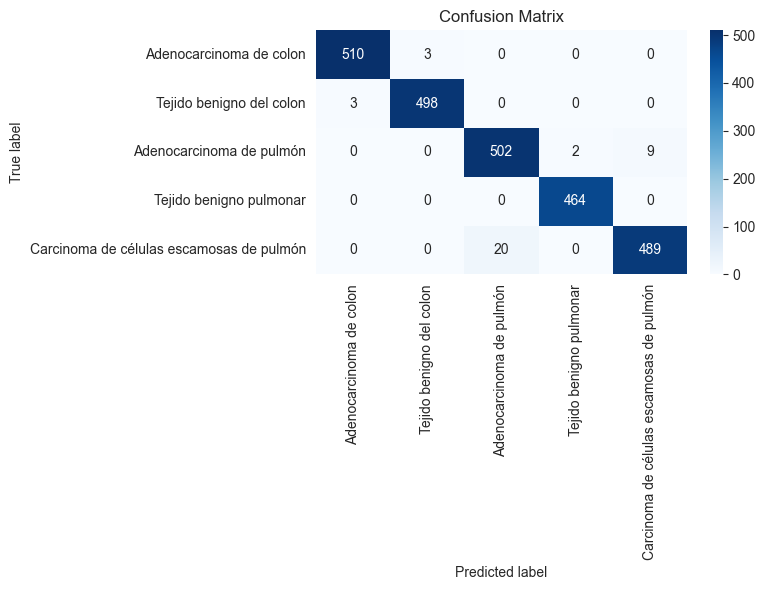

                                          precision    recall  f1-score   support

                 Adenocarcinoma de colon       0.99      0.99      0.99       513
                Tejido benigno del colon       0.99      0.99      0.99       501
                Adenocarcinoma de pulmón       0.96      0.98      0.97       513
                 Tejido benigno pulmonar       1.00      1.00      1.00       464
Carcinoma de células escamosas de pulmón       0.98      0.96      0.97       509

                                accuracy                           0.99      2500
                               macro avg       0.99      0.99      0.99      2500
                            weighted avg       0.99      0.99      0.99      2500



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

raw_classes = test_gen.dataset.dataset.classes  # ['colon_aca', 'colon_n', ...]
label_map = {
    'colon_aca': 'Adenocarcinoma de colon',
    'colon_n': 'Tejido benigno del colon',
    'lung_aca': 'Adenocarcinoma de pulmón',
    'lung_n': 'Tejido benigno pulmonar',
    'lung_scc': 'Carcinoma de células escamosas de pulmón'
}
final_class_names = [label_map[c] for c in raw_classes]

# true labels from test set
y_true = [label for _, label in test_gen.dataset]
y_true = np.array(y_true)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, final_class_names, title='Confusion Matrix')


print(classification_report(y_true, y_pred, target_names=final_class_names))

Destaco de este punto la precision del modelo con respecto a la predicción con respecto a celulas con label predecido como tejido pulmonar benigno que realmente eran benignos. En ese sentido, el modelo no comete errores que llevarían a una situacion compleja (catalogar a una persona enferma como sana). No ocurre lo mismo con el tejido benigno de colon donde el modelo erroneamente clasifica 3 imagenes de Adenocarcinoma de colon como tejido benigno de colon. Esto si es grave, es un error que se debería buscar mejorar para una situación real (similara a clasificar un mail no spam como spam) error tipo II.

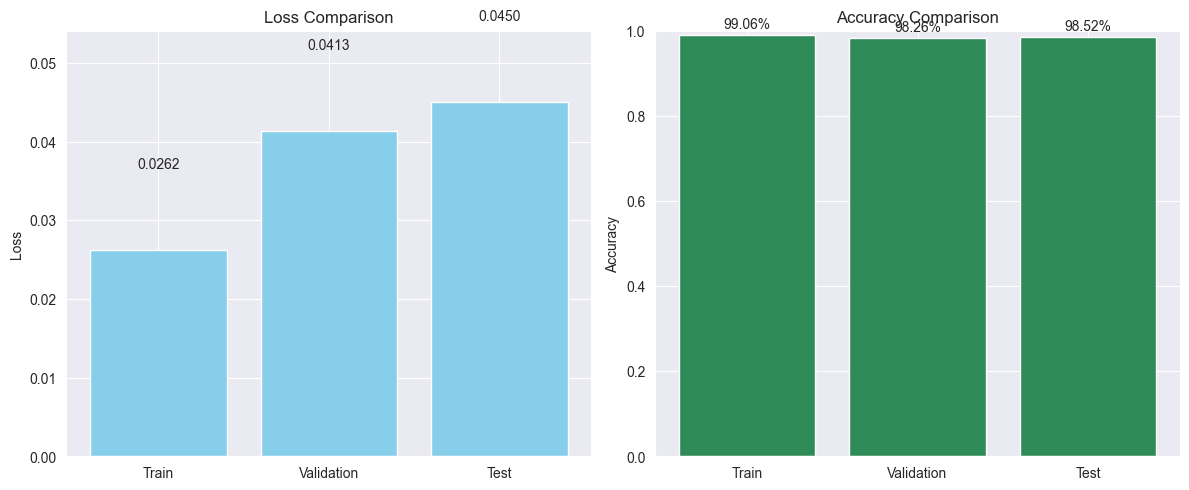

In [ ]:
import matplotlib.pyplot as plt

# data
phases = ['Train', 'Validation', 'Test']
losses = [train_loss, val_loss, test_loss]
accuracies = [train_acc, val_acc, test_acc]

# plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(phases, losses, color='skyblue')
plt.title("Loss Comparison")
plt.ylabel("Loss")
plt.ylim(0, max(losses) * 1.2)
for i, val in enumerate(losses):
    plt.text(i, val + 0.01, f"{val:.4f}", ha='center', va='bottom')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.bar(phases, accuracies, color='seagreen')
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
for i, val in enumerate(accuracies):
    plt.text(i, val + 0.01, f"{val:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# reverse normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def show_sample_predictions(model, dataloader, class_names, num_images=6, device='cuda'):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for i in range(inputs.size(0)):
                image = inv_normalize(inputs[i].cpu())
                image = image.permute(1, 2, 0).numpy()
                plt.subplot(2, num_images//2, images_shown + 1)
                plt.imshow(np.clip(image, 0, 1))
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                color = "green" if true_label == pred_label else "red"
                plt.title(f"True label: {true_label}\nPredicted label: {pred_label}", color=color)
                plt.axis('off')
                images_shown += 1
                if images_shown == num_images:
                    plt.tight_layout()
                    plt.show()
                    return


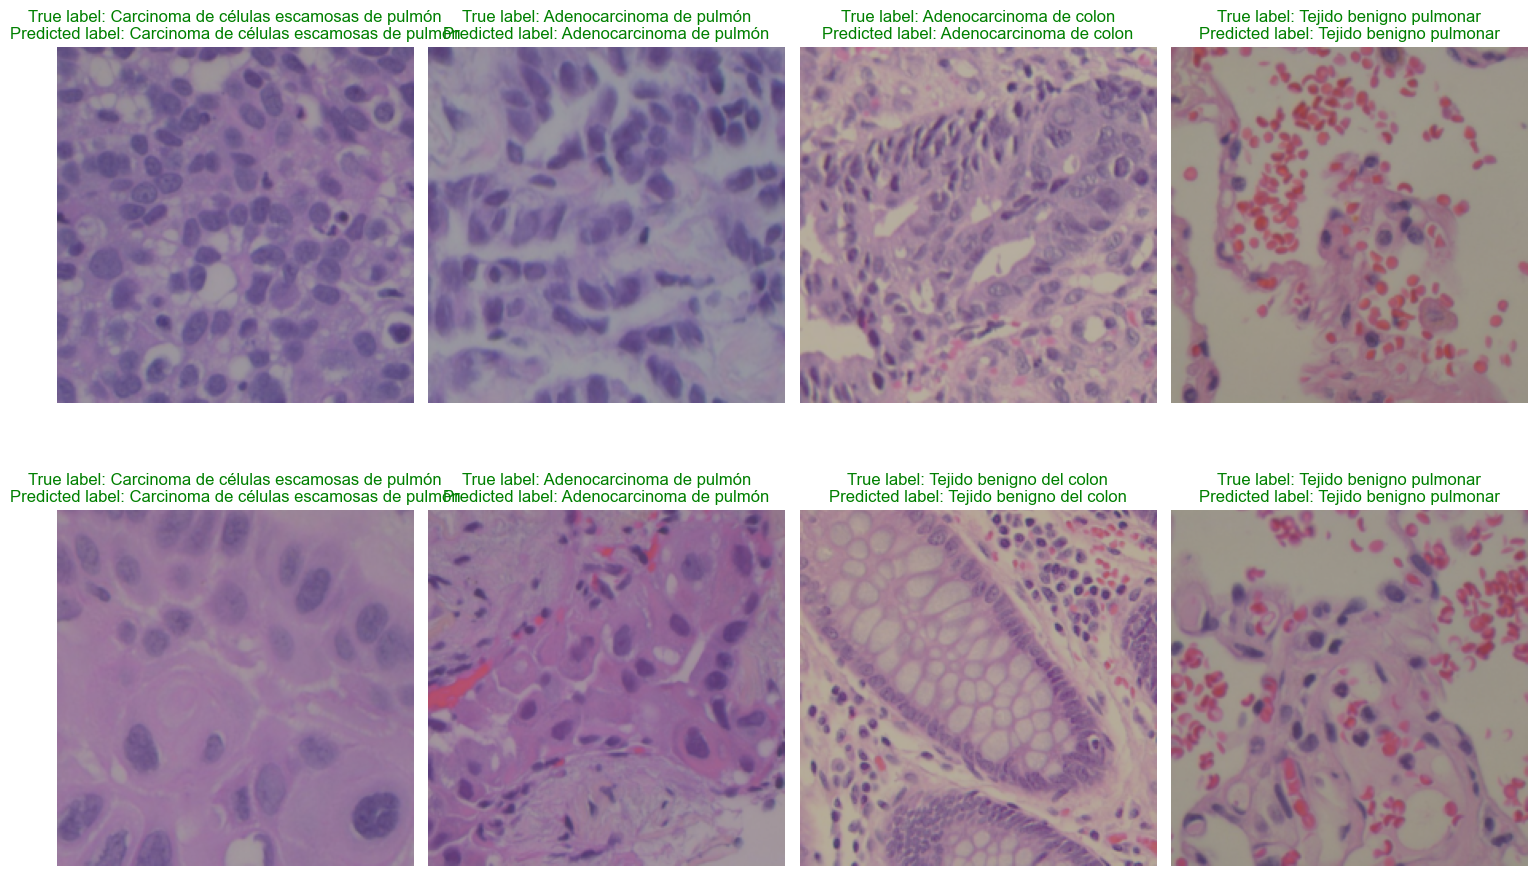

In [31]:
show_sample_predictions(model, test_gen, final_class_names, num_images=8, device='cuda')


En este grafico podemos apreciar las predicciones del modelo sobre el dataset de test. Observando una correcta categorización en las 8 imagenes tratadas.

In [32]:
import os
import torch



model_name = "VGGHistopathModel"

save_path = '.'
os.makedirs(save_path, exist_ok=True)

save_id = f'{model_name}.pt'
model_save_loc = os.path.join(save_path, save_id)
torch.save(model, model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Save only weights 
weight_save_id = f'{model_name}-weights.pth'
weights_save_loc = os.path.join(save_path, weight_save_id)
torch.save(model.state_dict(), weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')

Model was saved as .\VGGHistopathModel.pt
Weights were saved as .\VGGHistopathModel-weights.pth


En conclusión, se pudo observar que ambos modelos finales performan de una manera muy buena con respecto al dataset de test alcanzando precisiones cercanas al 99%. Quedará pendiente para algun momento con más disponibilidad de tiempo e información los siguientes dos puntos:

1. Validar el funcionamiento del modelo ante nueva información
2. Mejorar la precisión del modelo ante errores de tipo II como los cometidos con las celulas de colón.